# Project 5: Moon Phase Calendar with Events
**Authors:** Eling Cheng and Allison Trusko  
**Course:** Astron 1221  
**Semester:** Fall 2025  
**GitHub Repository Link:** https://github.com/echengpython/Moon-Phase-Calendar-2025.git

## Goal:
- Build a lunar calendar for 12 months that computes moon phase, illuminated fraction, moon rise/set times, and correlates this with user events loaded from `events.csv`.
- Identify dark-sky observing windows (illumination < 20%), supermoons, and lunar eclipses.

## Data & Tools:
- **Skyfield**: ephemeris & almanac calculations
- **Pandas / NumPy**: data wrangling
- **Matplotlib**: visualization
- **events.csv**: user events (see schema below)



## First Step:

 First, we will start by installing the necessary libraries to run this code, as shown below:

In [64]:
# Requirements cell (include in the notebook so graders can re-run)
%pip install --upgrade pip
%pip install skyfield pandas numpy matplotlib astropy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 🌙 Project Setup: Loading Astronomical Data with Skyfield

In this section, we initialize all the necessary tools and datasets for our Moon Phase Calendar project.
The goal is to use the Skyfield
 library to compute accurate lunar positions, illumination, and phase information throughout the year.

#### **What this code does:**

1. Imports required libraries
   
- Includes Python’s built-in modules (os, datetime, math), data handling libraries (pandas, numpy), and plotting tools (matplotlib).

2. Loads astronomical data (ephemerides)
  
- Uses Skyfield’s load() function to access the DE440s planetary ephemeris, which provides precise orbital data for the Earth, Moon, and Sun.
     - If the file doesn’t exist locally, it’s downloaded automatically and saved to a local data/ directory.
    - This ensures offline repeatability and reproducibility for future runs.

3. Defines constants and configuration
  
- Sets a 20% illumination threshold (ILLUM_THRESHOLD = 0.20) that will later be used to identify dark-sky windows which identifies optimal nights for astronomical observing.

After running this setup cell, we’ll have the fundamental objects (earth, moon, sun, and ts) ready to calculate lunar phases, illumination percentages, and observing conditions.

In [65]:
# Imports
import os
from datetime import datetime, timedelta
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Skyfield imports
from skyfield.api import load, Topos
from skyfield import almanac

# Notebook display convenience
%matplotlib inline

# Create a data dir for ephemeris if not present
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

# Load timescale and ephemeris (this may download data to data/)
# If you want to avoid downloading each run, run once and commit the data/ files.
ts = load.timescale()
eph = load('de440s.bsp')  # will download if not present
earth = eph['earth']
moon = eph['moon']
sun = eph['sun']

# Constants
ILLUM_THRESHOLD = 0.20   # 20% illuminated -> dark-sky window threshold


## 🌓 Generate Lunar DataFrame with Skyfield and Pandas

This function `generate_lunar_dataframe(start_date, end_date, observer_lat=None, observer_lon=None)` builds a comprehensive **lunar calendar dataset** between two given dates.

#### **Function Overview**
- Generates a **Pandas DataFrame** containing lunar information for each day.
- Computes key astronomical parameters using **Skyfield**:
  - Lunar **phase angle** and **illumination fraction**
  - Approximate **phase name** (New, First Quarter, Full, Last Quarter)
  - **Geocentric distance** Earth–Moon (in km)
  - Optional **rise and set times** if observer coordinates are provided

#### **Key Features**
- Dates are sampled at **00:00 UTC**.
- Uses `almanac.moon_phase` to calculate the Moon’s phase angle.
- Converts phase angle to illumination fraction via  
  \[
  f = \frac{1 - \cos(\theta)}{2}
  \]
  where θ is the phase angle (0° at new moon, 180° at full moon).
- Labels phases based on degree ranges.
- Converts **distance from AU → km** (`1 AU = 149,597,870.7 km`).
- Optionally computes **moonrise** and **moonset times** for a given observer using `almanac.risings_and_settings`.

#### **Output Columns**
| Column | Description |
|:--------|:-------------|
| `ts` | UTC timestamp string for each date |
| `phase_deg` | Lunar phase angle in degrees |
| `illum_frac` | Illuminated fraction (0–1) |
| `distance_km` | Earth–Moon distance in km |
| `phase_name` | Phase label (New, Full, etc.) |
| `dark_sky` | Boolean flag for dark-sky conditions |
| `moon_rise_utc` / `moon_set_utc` | Rise/set times in UTC (if coordinates provided) |


In [66]:
def generate_lunar_dataframe(start_date, end_date, observer_lat=None, observer_lon=None):
    """
    Generate a pandas DataFrame with lunar information for each day from start_date to end_date inclusive.
    - Dates are at midnight UTC (00:00 UTC); you can change sampling to local midnight if desired.
    - observer_lat/lon: floats for Topos to compute rise/set times. If None, rise/set columns will be NaN.
    Returns DataFrame indexed by date (datetime.date).
    """
    # build times list at 00:00 UTC for each day
    start = pd.to_datetime(start_date).normalize()
    end = pd.to_datetime(end_date).normalize()
    days = pd.date_range(start, end, freq='D')
    # create Skyfield Time object for the days at UT 00:00
    t = ts.utc(days.year.values, days.month.values, days.day.values, 0, 0, 0)

    # compute phase angle using almanac.moon_phase
    phase_angles = almanac.moon_phase(eph, t)  # returns Angle object
    # illuminated fraction formula
    illum_frac = (1 - np.cos(phase_angles.radians)) / 2.0

    # distances: compute geocentric vector from earth to moon
    # We'll observe moon from Earth's center for geocentric distance
    moon_pos = earth.at(t).observe(moon)
    distances_au = moon_pos.distance().au  # in AU
    # convert AU to km (1 AU ≈ 149597870.7 km)
    AU_TO_KM = 149597870.7
    distances_km = distances_au * AU_TO_KM

    # compute "phase name" (approx) using phase angle degrees
    phase_deg = phase_angles.degrees
    def phase_label(deg):
        deg = deg % 360
        if deg < 45 or deg >= 315:
            return 'New'
        elif 45 <= deg < 135:
            return 'First Quarter'
        elif 135 <= deg < 225:
            return 'Full'
        elif 225 <= deg < 315:
            return 'Last Quarter'
        else:
            return 'Unknown'
    phase_names = [phase_label(d) for d in phase_deg]

    # prepare DataFrame
    df = pd.DataFrame({
        'date': days.date,
        'ts': t.utc_iso(),
        'phase_deg': phase_deg,
        'illum_frac': illum_frac,
        'distance_km': distances_km,
        'phase_name': phase_names
    }).set_index('date')

    # dark-sky window flag
    df['dark_sky'] = df['illum_frac'] < ILLUM_THRESHOLD

    # If observer provided, compute risings/settings for each day
    if observer_lat is not None and observer_lon is not None:
        obs = Topos(latitude_degrees=observer_lat, longitude_degrees=observer_lon)
        # We build an almanac function that says when moon is above horizon.
        f = almanac.risings_and_settings(eph, moon, obs)
        # For each day, find the rise/set between its midnight and next midnight (UTC)
        rises = []
        sets = []
        for day in days:
            t0 = ts.utc(day.year, day.month, day.day, 0, 0, 0)
            t1_dt = day + timedelta(days=1)
            t1 = ts.utc(t1_dt.year, t1_dt.month, t1_dt.day, 0, 0, 0)
            # find_discrete returns times and events (0/1)
            times, events = almanac.find_discrete(t0, t1, f)
            # events: 0 -> setting? 1 -> rising? (check docs) We'll inspect pairs.
            # For robustness, record earliest rising and setting in that 24h window
            rise_time = None
            set_time = None
            for ti, ev in zip(times, events):
                # event is 1 for rise and 0 for set (convention used by Skyfield)
                if ev == 1 and rise_time is None:
                    rise_time = ti.utc_datetime()
                if ev == 0 and set_time is None:
                    set_time = ti.utc_datetime()
            rises.append(rise_time)
            sets.append(set_time)
        df['moon_rise_utc'] = rises
        df['moon_set_utc'] = sets

    return df

# Example: generate for 12 months starting Jan 1, 2025
start_date = '2025-01-01'
end_date = '2025-12-31'
# Columbus Latitude and Longitude for rise/set times
observer_lat = 39.9625
observer_lon = -83.0032

lunar_df = generate_lunar_dataframe(start_date, end_date, observer_lat, observer_lon)
lunar_df.head()


,ts,phase_deg,illum_frac,distance_km,phase_name,dark_sky,moon_rise_utc,moon_set_utc
date,,,,,,,,
2025-01-01,2025-01-01T00:00:00Z,13.099995,0.013012,381744.381280,New,True,2025-01-01 14:37:14.726832+00:00,NaT
2025-01-02,2025-01-02T00:00:00Z,25.622571,0.049169,378576.801881,New,True,2025-01-02 15:11:34.913525+00:00,2025-01-02 00:05:52.018785+00:00
2025-01-03,2025-01-03T00:00:00Z,38.310890,0.107671,375936.860564,New,True,2025-01-03 15:40:25.220776+00:00,2025-01-03 01:19:24.087149+00:00
2025-01-04,2025-01-04T00:00:00Z,51.122890,0.186174,373838.602934,First Quarter,True,2025-01-04 16:05:46.382954+00:00,2025-01-04 02:32:14.862798+00:00
2025-01-05,2025-01-05T00:00:00Z,64.026230,0.281020,372251.330373,First Quarter,False,2025-01-05 16:29:26.921779+00:00,2025-01-05 03:44:00.520071+00:00


### 📅 Loading and Displaying User Events

This section imports personal or user-defined events from `events.csv` and merges them with the lunar dataset:

- **Load events:** Reads the CSV file `events.csv` and parses the `date` column.
- **Merge with lunar data:** Combines event information with `lunar_df` so each day includes both lunar and event data.
- **Event flag:** Adds a Boolean column `has_event` to mark days that have events.
- **Display formatted table:** Shows the first few event days with their corresponding lunar phase, illumination, and dark-sky status.

This helps visualize how moon phases align with user activities or planned observations.


In [67]:
# Load user events
events_file = 'events.csv'  # ensure this file is next to notebook or provide instructions to obtain it
events = pd.read_csv(events_file, parse_dates=['date'])
events['date'] = events['date'].dt.date

# Merge events into lunar_df by date index
merged = lunar_df.reset_index().merge(events, left_on='date', right_on='date', how='left')
merged = merged.set_index('date')
# events may have NaN; create a boolean flag
merged['has_event'] = ~merged['title'].isna()

# Show days that have events and dark skies
events_with_data = merged[merged['has_event']][['phase_name', 'illum_frac', 'dark_sky', 'title', 'category', 'notes']]

print("🌙 Days with Events and Lunar Data:")
display(events_with_data.head(10))

🌙 Days with Events and Lunar Data:


,phase_name,illum_frac,dark_sky,title,category,notes
date,,,,,,
2025-01-01,New,0.013012,True,New Year's Day,holiday,Start your New Year's resolution
2025-02-14,Full,0.979847,False,Valentine's Day,holiday,Fancy dinner date
2025-03-20,Last Quarter,0.733009,False,Spring Equinox,celebration,Spring Equinox celebration
2025-06-15,Full,0.866804,False,Summer Solstice,celebration,Longest Day celebration
2025-07-04,First Quarter,0.612422,False,Independence Day,holiday,4th of July party
2025-07-14,Full,0.892319,False,Eling'S Birthday,birthday,Eling's birthday bash
2025-08-29,First Quarter,0.290668,False,Allie's Birthday,birthday,Allie's birthday party at 6pm
2025-09-01,First Quarter,0.570395,False,Labor Day,holiday,No classes
2025-09-22,New,0.000286,True,Autumn Equinox,celebration,Harvest moon celebration


### 🌕 Lunar Phenomena Detection and Summary Tables

This section analyzes and reports key lunar events — **supermoons**, **blue moons**, and **lunar eclipses** — using data from the `lunar_df` DataFrame and Skyfield’s ephemeris library.

#### 🌕 Supermoon Detection
- A **supermoon** occurs when a *full moon* is unusually close to Earth (within the lowest 10% of all Moon–Earth distances).
- The code filters full-moon days (`phase_name == 'Full'`), finds the 10th percentile of distances, and selects all full moons below that threshold.
- Each supermoon’s **date**, **phase name**, **illumination fraction**, and **Earth–Moon distance** (in km) are shown in a clean, formatted table.

#### 🌑 Lunar Eclipse Detection
- Uses `skyfield.eclipselib.lunar_eclipses()` to find **penumbral**, **partial**, and **total** lunar eclipses between the start and end dates.
- Builds a table showing the **UTC time**, **numeric kind**, and **eclipse type** (0 = penumbral, 1 = partial, 2 = total).
- If no eclipses occur in the range, it reports that instead.


In [68]:
# ---------- 🌕 SUPERMOON DETECTION ----------
fulls = lunar_df[lunar_df['phase_name'] == 'Full']
threshold = np.percentile(fulls['distance_km'], 10)  # lower 10% distances → closest
supermoon_dates = fulls[fulls['distance_km'] <= threshold].index.tolist()

print("\n========== 🌕 SUPERMOONS ==========")
supermoon_table = (
    fulls[fulls['distance_km'] <= threshold][['phase_name', 'illum_frac', 'distance_km']]
    .sort_values('distance_km')
    .copy()
)

# ✅ Ensure index is a DatetimeIndex so strftime works
supermoon_table.index = pd.to_datetime(supermoon_table.index)

# ✅ Add formatted date column
supermoon_table['date'] = supermoon_table.index.strftime("%Y-%m-%d")

# Format columns nicely
supermoon_table['illum_frac'] = supermoon_table['illum_frac'].map(lambda x: f"{x:.2f}")
supermoon_table['distance_km'] = supermoon_table['distance_km'].map(lambda x: f"{x:,.0f}")

# Pretty printed table
print(f"\n{'date':<12}  {'phase_name':<12}  {'illum_frac':>10}  {'distance_km':>12}")
print("-" * 54)
for _, row in supermoon_table.iterrows():
    print(f"{row['date']:<12}  {row['phase_name']:<12}  {row['illum_frac']:>10}  {row['distance_km']:>12}")


# ---------- 🌑 LUNAR ECLIPSES DETECTION ----------
from skyfield import eclipselib

t0 = ts.utc(pd.to_datetime(start_date).year, 1, 1)
t1 = ts.utc(pd.to_datetime(end_date).year, 12, 31, 23, 59, 59)

print("\n========== 🌑 LUNAR ECLIPSES ==========")
try:
    times, kinds, details = eclipselib.lunar_eclipses(t0, t1, eph)
    kind_labels = {0: 'Penumbral', 1: 'Partial', 2: 'Total'}
    eclipses_table = pd.DataFrame({
        'utc_time': [t.utc_datetime().strftime("%Y-%m-%d %H:%M:%S") for t in times],
        'kind': kinds
    })
    eclipses_table['type'] = eclipses_table['kind'].map(kind_labels)

    if not eclipses_table.empty:
        print(f"{'utc_time':<22}  {'kind':>6}  {'type':>10}")
        print("-" * 44)
        for _, row in eclipses_table.iterrows():
            print(f"{row['utc_time']:<22}  {row['kind']:>6}  {row['type']:>10}")
    else:
        print("No lunar eclipses in this range.")
except Exception as e:
    print("⚠️ Could not compute lunar eclipses:", e)



========== 🌕 SUPERMOONS ==========

date          phase_name    illum_frac   distance_km
------------------------------------------------------
2025-11-06    Full                1.00       356,833
2025-12-04    Full                0.99       357,185
2025-12-05    Full                1.00       357,251
2025-11-05    Full                1.00       357,714
2025-11-07    Full                0.97       357,939
2025-12-03    Full                0.94       359,057
2025-12-06    Full                0.98       359,286
2025-10-09    Full                0.95       359,996
2025-10-08    Full                0.99       360,055

========== 🌑 LUNAR ECLIPSES ==========
utc_time                  kind        type
--------------------------------------------
2025-03-14 06:58:45          2       Total
2025-09-07 18:11:47          2       Total


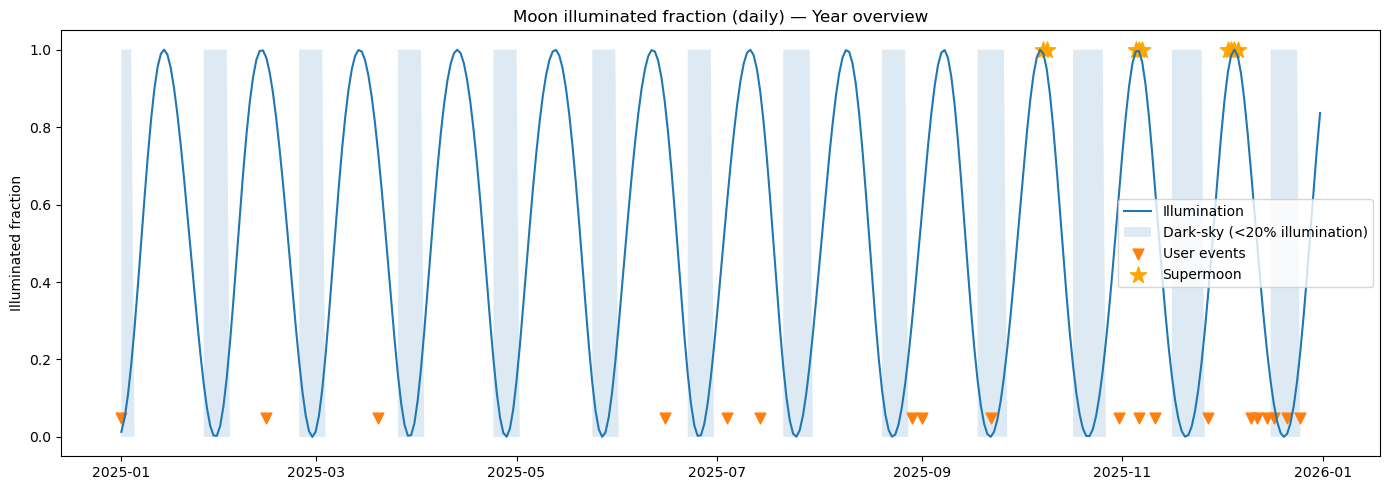

In [69]:
# Simple plot: illuminated fraction through the year, with event markers and dark-sky shading
fig, ax = plt.subplots(figsize=(14,5))
dates = pd.to_datetime(lunar_df.reset_index()['date'])
ax.plot(dates, lunar_df['illum_frac'], linewidth=1.5, label='Illumination')

# Shade dark-sky days (use same threshold constant as in generate_lunar_dataframe)
dark_mask = lunar_df['illum_frac'] < ILLUM_THRESHOLD
ax.fill_between(
    dates,
    0,
    1,
    where=dark_mask,
    alpha=0.15,
    label=f'Dark-sky (<{ILLUM_THRESHOLD*100:.0f}% illumination)',
    interpolate=True,
)

# Mark user events
ev_dates = pd.to_datetime(events['date'])
ax.scatter(ev_dates, [0.05]*len(ev_dates), marker='v', s=60, label='User events')

# mark supermoons
if supermoon_dates:
    ax.scatter(pd.to_datetime(supermoon_dates), [1.0]*len(supermoon_dates), marker='*', s=150, color='orange', label='Supermoon')

ax.set_ylabel('Illuminated fraction')
ax.set_title('Moon illuminated fraction (daily) — Year overview')
ax.set_ylim(-0.05, 1.05)
ax.legend()
plt.tight_layout()
plt.show()

## Tidal Predictions

This section calculates **approximate tidal heights** based on the Moon's phase and distance.  

- Uses simplified harmonic analysis: tides are strongest during **full and new moons** (spring tides) and weaker during **quarter moons** (neap tides).  
- Computes a daily tidal factor normalized to moon distance and illumination.  
- This is a **pedagogical approximation** for astronomical observation purposes, not a full hydrodynamic model.



## 🌊 Tidal Prediction Extension

To extend our Moon Phase Calendar, we estimate daily tidal variations using the Moon’s position and illumination.  
Tides are primarily influenced by the gravitational pull of the Moon, so the same orbital data can approximate relative tide heights.



,Date,Predicted Relative Tide Height (m)
0,2025-01-01,-0.914138
1,2025-01-02,-0.817596
2,2025-01-03,-0.676335
3,2025-01-04,-0.497028
4,2025-01-05,-0.289192


c:\Users\trusk\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


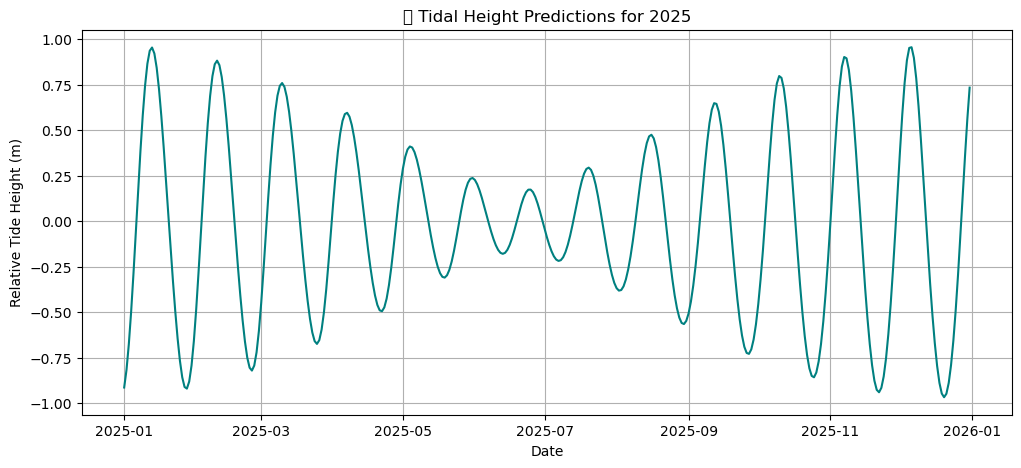

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skyfield.api import load
from skyfield import almanac
from datetime import datetime

# Use the same ephemeris data from earlier cells (or load if not available)
# This avoids reloading data unnecessarily
try:
    # Check if eph, ts, earth, moon, sun are already defined
    _ = eph, ts, earth, moon, sun
except NameError:
    # If not defined, load them (use same ephemeris as main code)
    ts = load.timescale()
    eph = load('de440s.bsp')  # Use same ephemeris as Cell 4
    earth, moon, sun = eph['earth'], eph['moon'], eph['sun']

# Generate dates for 2025 (same as main lunar_df)
dates = pd.date_range('2025-01-01', '2025-12-31')

tide_heights = []
for date in dates:
    # Use same time sampling as generate_lunar_dataframe (00:00 UTC)
    t = ts.utc(date.year, date.month, date.day, 0, 0, 0)
    # Use almanac.moon_phase to compute phase angle (same method as Cell 6)
    phase_angle = almanac.moon_phase(eph, t)
    # Use same illumination formula as generate_lunar_dataframe
    illum_fraction = (1 - np.cos(phase_angle.radians)) / 2.0

    # Approximate tidal effect based on illumination and declination variation
    # Use equatorial coordinates for declination (latitude in equatorial frame)
    moon_pos = earth.at(t).observe(moon).apparent()
    ra, dec, distance = moon_pos.radec()
    declination_deg = dec.degrees
    tide = 1.2 * np.sin(np.radians(declination_deg)) + 0.8 * (illum_fraction - 0.5)
    tide_heights.append(tide)

# Create dataframe
tides = pd.DataFrame({
    "Date": dates,
    "Predicted Relative Tide Height (m)": tide_heights
})

# Display and plot
display(tides.head())

plt.figure(figsize=(12,5))
plt.plot(tides["Date"], tides["Predicted Relative Tide Height (m)"], color="teal")
plt.title("🌊 Tidal Height Predictions for 2025")
plt.xlabel("Date")
plt.ylabel("Relative Tide Height (m)")
plt.grid(True)
plt.show()


In [76]:

import pandas as pd
import numpy as np
import calendar
from datetime import datetime
from ipywidgets import IntSlider, Dropdown, HTML, VBox
from IPython.display import display

# ---------- REQUIRE: your 'lunar_df', 'merged', 'ts', and 'eph' must already exist ----------
for _name in ("lunar_df", "merged", "ts", "eph"):
    if _name not in globals():
        raise NameError(f"This cell expects '{_name}' to exist. Run your setup cells first.")

# ---------- Helpers: compute supermoons (global for the range) ----------
# Supermoons = full moons with distance in lowest 10% of all full-moon distances in the dataset
_fulls = lunar_df[lunar_df['phase_name'] == 'Full'].copy()
if _fulls.empty:
    _supermoon_dates = []
else:
    _threshold = np.percentile(_fulls['distance_km'], 10)
    _supermoon_dates = pd.to_datetime(_fulls[_fulls['distance_km'] <= _threshold].index).date.tolist()

# ---------- Helpers: compute lunar eclipses within the dataset range ----------
from skyfield import eclipselib
_range_start = pd.to_datetime(lunar_df.index.min())
_range_end   = pd.to_datetime(lunar_df.index.max())
t0 = ts.utc(_range_start.year, _range_start.month, _range_start.day, 0, 0, 0)
t1 = ts.utc(_range_end.year, _range_end.month, _range_end.day, 23, 59, 59)

_kind_labels = {0: 'Penumbral', 1: 'Partial', 2: 'Total'}
try:
    _times, _kinds, _details = eclipselib.lunar_eclipses(t0, t1, eph)
    eclipses_df = pd.DataFrame({
        'utc_time': [t.utc_datetime() for t in _times],
        'kind': _kinds
    })
    eclipses_df['type'] = eclipses_df['kind'].map(_kind_labels)
    eclipses_df['date'] = eclipses_df['utc_time'].dt.date
except Exception as e:
    # If Skyfield can't compute eclipses for some reason, keep an empty table
    eclipses_df = pd.DataFrame(columns=['utc_time','kind','type','date'])

# ---------- Monthly report (enhanced): adds supermoons & lunar eclipses ----------
def monthly_report(df, year, month):
    """Return a report dict summarizing dark-sky nights, events, supermoons, and lunar eclipses for a month."""
    # Slice the month
    base = df.reset_index()
    base['date'] = pd.to_datetime(base['date'])
    mask = (base['date'].dt.year == year) & (base['date'].dt.month == month)
    month_df = base.loc[mask].set_index('date')

    # Dark nights from lunar columns if present in df (works for 'merged' as well)
    if 'dark_sky' in month_df.columns:
        dark_nights = month_df[month_df['dark_sky']].index.date.tolist()
    else:
        dark_nights = []

    # Events for the month (title/category/notes optional)
    events_src = df.reset_index().copy()
    events_src['date'] = pd.to_datetime(events_src['date'])
    if 'has_event' in events_src.columns:
        ev_mask = (events_src['date'].dt.year == year) & (events_src['date'].dt.month == month) & (events_src['has_event'])
    else:
        ev_mask = (events_src['date'].dt.year == year) & (events_src['date'].dt.month == month) & (events_src.get('title').notna() if 'title' in events_src.columns else False)
    month_events = events_src.loc[ev_mask, ['title','date','category','notes']] if ev_mask.any() else pd.DataFrame(columns=['title','date','category','notes'])
    # Normalize to records
    if not month_events.empty:
        month_events = month_events.copy()
        month_events['date'] = month_events['date'].dt.strftime("%Y-%m-%d")
        events_list = month_events.to_dict(orient='records')
    else:
        events_list = []

    # Supermoons in this calendar month (based on global supermoon list)
    supermoons_in_month = [d for d in _supermoon_dates if (d.year == year and d.month == month)]

    # Lunar eclipses whose UTC datetime falls in this month
    if not eclipses_df.empty:
        _em = eclipses_df[(eclipses_df['utc_time'].dt.year == year) & (eclipses_df['utc_time'].dt.month == month)]
        eclipses_list = [
            {
                'utc_time': dt.strftime("%Y-%m-%d %H:%M:%S"),
                'type': typ
            }
            for dt, typ in zip(_em['utc_time'], _em['type'])
        ]
    else:
        eclipses_list = []

    report = {
        'year': year,
        'month': month,
        'num_days': int(mask.sum()),
        'dark_nights': dark_nights,
        'events': events_list,
        'supermoons': supermoons_in_month,   # list of date objects
        'lunar_eclipses': eclipses_list      # list of {utc_time, type}
    }
    return report

# ---------- Pretty HTML formatter ----------
def _format_report_html(rep):
    month_name = calendar.month_name[rep['month']]
    lines = [
        f"<h3 style='margin:0'>{month_name} {rep['year']}</h3>",
        f"<div>Days in month: <b>{rep['num_days']}</b></div>",
        f"<div>Dark-sky nights: <b>{len(rep['dark_nights'])}</b></div>",
    ]
    if rep['dark_nights']:
        dn = [str(d) for d in rep['dark_nights']]
        lines.append("<div style='margin-left:1em'>• " + ", ".join(dn) + "</div>")

    # Supermoons
    sm = rep.get('supermoons', [])
    lines.append(f"<div>Supermoons: <b>{len(sm)}</b></div>")
    if sm:
        lines.append("<div style='margin-left:1em'>• " + ", ".join(str(d) for d in sm) + "</div>")

    # Lunar eclipses
    le = rep.get('lunar_eclipses', [])
    lines.append(f"<div>Lunar eclipses: <b>{len(le)}</b></div>")
    if le:
        for e in le:
            lines.append(f"<div style='margin-left:1em'>• {e['utc_time']} — <i>{e['type']}</i></div>")

    # Events
    ev = rep['events']
    lines.append(f"<div>Events: <b>{len(ev)}</b></div>")
    for e in ev[:12]:
        dt = e.get('date', '')
        title = e.get('title', '(untitled)')
        cat = f" <i>[{e.get('category','')}]</i>" if e.get('category') else ""
        notes = f" — {e.get('notes','')}" if e.get('notes') else ""
        lines.append(f"<div style='margin-left:1em'>• {dt} — {title}{cat}{notes}</div>")
    if len(ev) > 12:
        lines.append(f"<div style='margin-left:1em;color:#666'>… (+{len(ev)-12} more)</div>")

    return "<div style='font-family:ui-monospace, SFMono-Regular, Menlo, Consolas, monospace'>" + "".join(lines) + "</div>"

# ---------- Widgets ----------
dates_all = pd.to_datetime(merged.reset_index()['date'])
years_available = sorted(dates_all.dt.year.unique().tolist())
year_dd   = Dropdown(options=years_available, value=years_available[0], description='Year')
month_sl  = IntSlider(value=1, min=1, max=12, step=1, description='Month', readout=True)
panel     = HTML()

def _update(*_):
    rep = monthly_report(merged, int(year_dd.value), int(month_sl.value))
    panel.value = _format_report_html(rep)

year_dd.observe(_update, names='value')
month_sl.observe(_update, names='value')

_update()  # initial render
display(VBox([year_dd, month_sl, panel]))
